In [1]:
!pip install tensor-dash

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls

drive  sample_data


In [4]:
import pandas as pd

In [5]:
dataset = pd.read_csv('/content/drive/MyDrive/Plant disease detection/train.csv')

In [6]:
!apt-get -qq install -y libfluidsynth1

E: Package 'libfluidsynth1' has no installation candidate


In [7]:
#Importing libraries
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensordash.tensordash import Tensordash
import plotly.express as px
import json
import skimage.io as io
#user_secrets = UserSecretsClient()
#secret_value_0 = user_secrets.get_secret("email")
#secret_value_1 = user_secrets.get_secret("pin")


In [8]:
dataset

image_id  healthy  multiple_diseases  rust  scab
0        Train_0        0                  0     0     1
1        Train_1        0                  1     0     0
2        Train_2        1                  0     0     0
3        Train_3        0                  0     1     0
4        Train_4        1                  0     0     0
...          ...      ...                ...   ...   ...
1816  Train_1816        0                  0     0     1
1817  Train_1817        1                  0     0     0
1818  Train_1818        1                  0     0     0
1819  Train_1819        0                  0     1     0
1820  Train_1820        0                  0     0     1

[1821 rows x 5 columns]

In [9]:
#Checking if there are any nullvalues
dataset.isnull().any()

image_id             False
healthy              False
multiple_diseases    False
rust                 False
scab                 False
dtype: bool

In [10]:
#Checking the column data type
dataset.dtypes

image_id             object
healthy               int64
multiple_diseases     int64
rust                  int64
scab                  int64
dtype: object

In [11]:
#Adding.jpg extension to every image_id
dataset['image_id'] = dataset['image_id']+'.jpg'

In [12]:
dataset

image_id  healthy  multiple_diseases  rust  scab
0        Train_0.jpg        0                  0     0     1
1        Train_1.jpg        0                  1     0     0
2        Train_2.jpg        1                  0     0     0
3        Train_3.jpg        0                  0     1     0
4        Train_4.jpg        1                  0     0     0
...              ...      ...                ...   ...   ...
1816  Train_1816.jpg        0                  0     0     1
1817  Train_1817.jpg        1                  0     0     0
1818  Train_1818.jpg        1                  0     0     0
1819  Train_1819.jpg        0                  0     1     0
1820  Train_1820.jpg        0                  0     0     1

[1821 rows x 5 columns]

Text(0.5, 1.0, 'Healthy Classes')

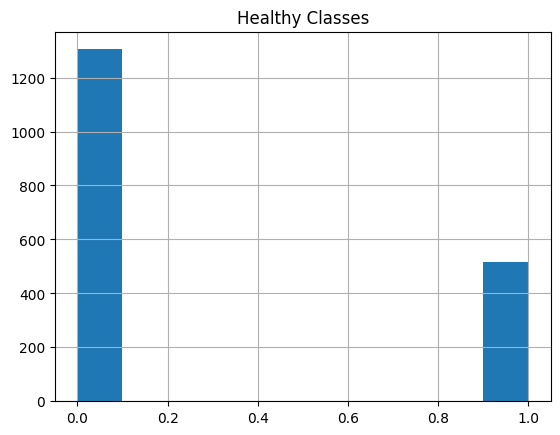

In [13]:
dataset.healthy.hist()
plt.title('Healthy Classes')

Text(0.5, 1.0, 'Multiple Diseases Classes')

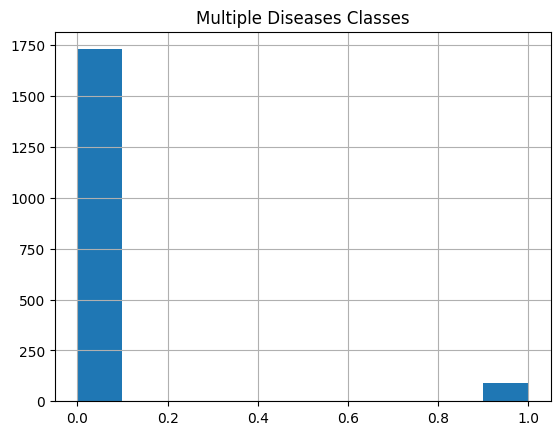

In [14]:
dataset.multiple_diseases.hist()
plt.title('Multiple Diseases Classes')

Text(0.5, 1.0, 'Rust Classes')

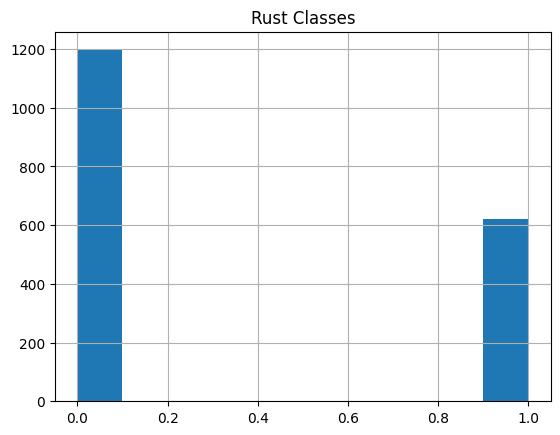

In [15]:
dataset.rust.hist()
plt.title('Rust Classes')

Text(0.5, 1.0, 'Scab Classes')

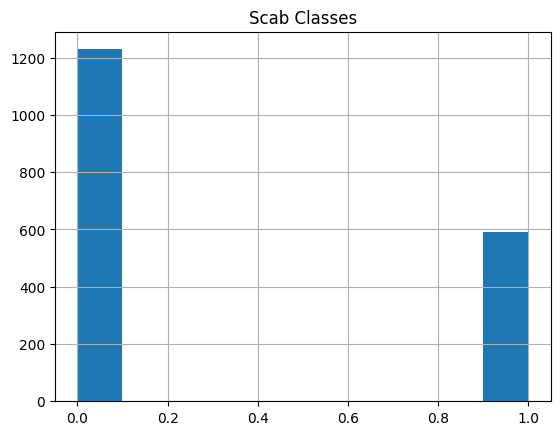

In [16]:
dataset.scab.hist()
plt.title('Scab Classes')

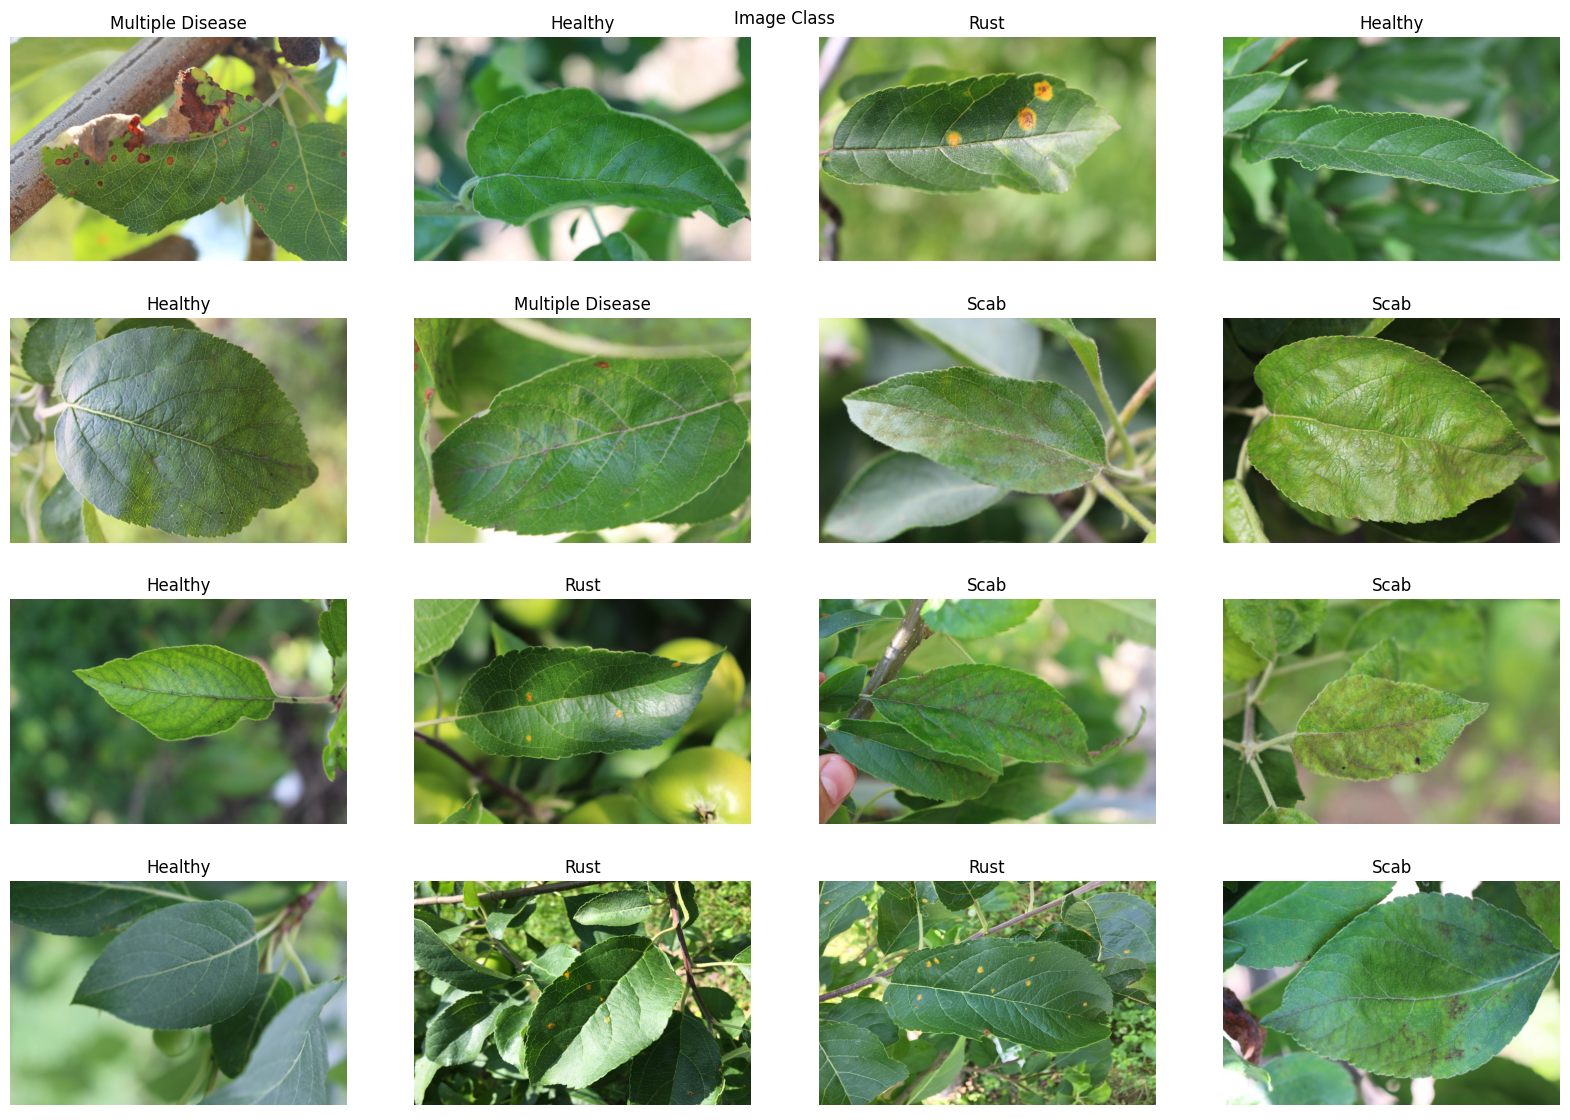

In [17]:
#class image visualization
w=10
h=10
fig=plt.figure(figsize=(20, 14))
columns = 4
rows = 4
plt.title('Image Class')
plt.axis('off')
for i in range(1, columns * rows + 1):
    img = plt.imread(f'/content/drive/MyDrive/Plant disease detection/images/Train_{i}.jpg')
    fig.add_subplot(rows, columns, i)

    if dataset.healthy[i] == 1:
        plt.title('Healthy')
    elif dataset.multiple_diseases[i] == 1:
        plt.title('Multiple Disease')
    elif dataset.rust[i] == 1:
      plt.title('Rust')
    else:
      plt.title('Scab')
    plt.imshow(img)
    plt.axis('off')
plt.show()


In [18]:
!pip install pillow

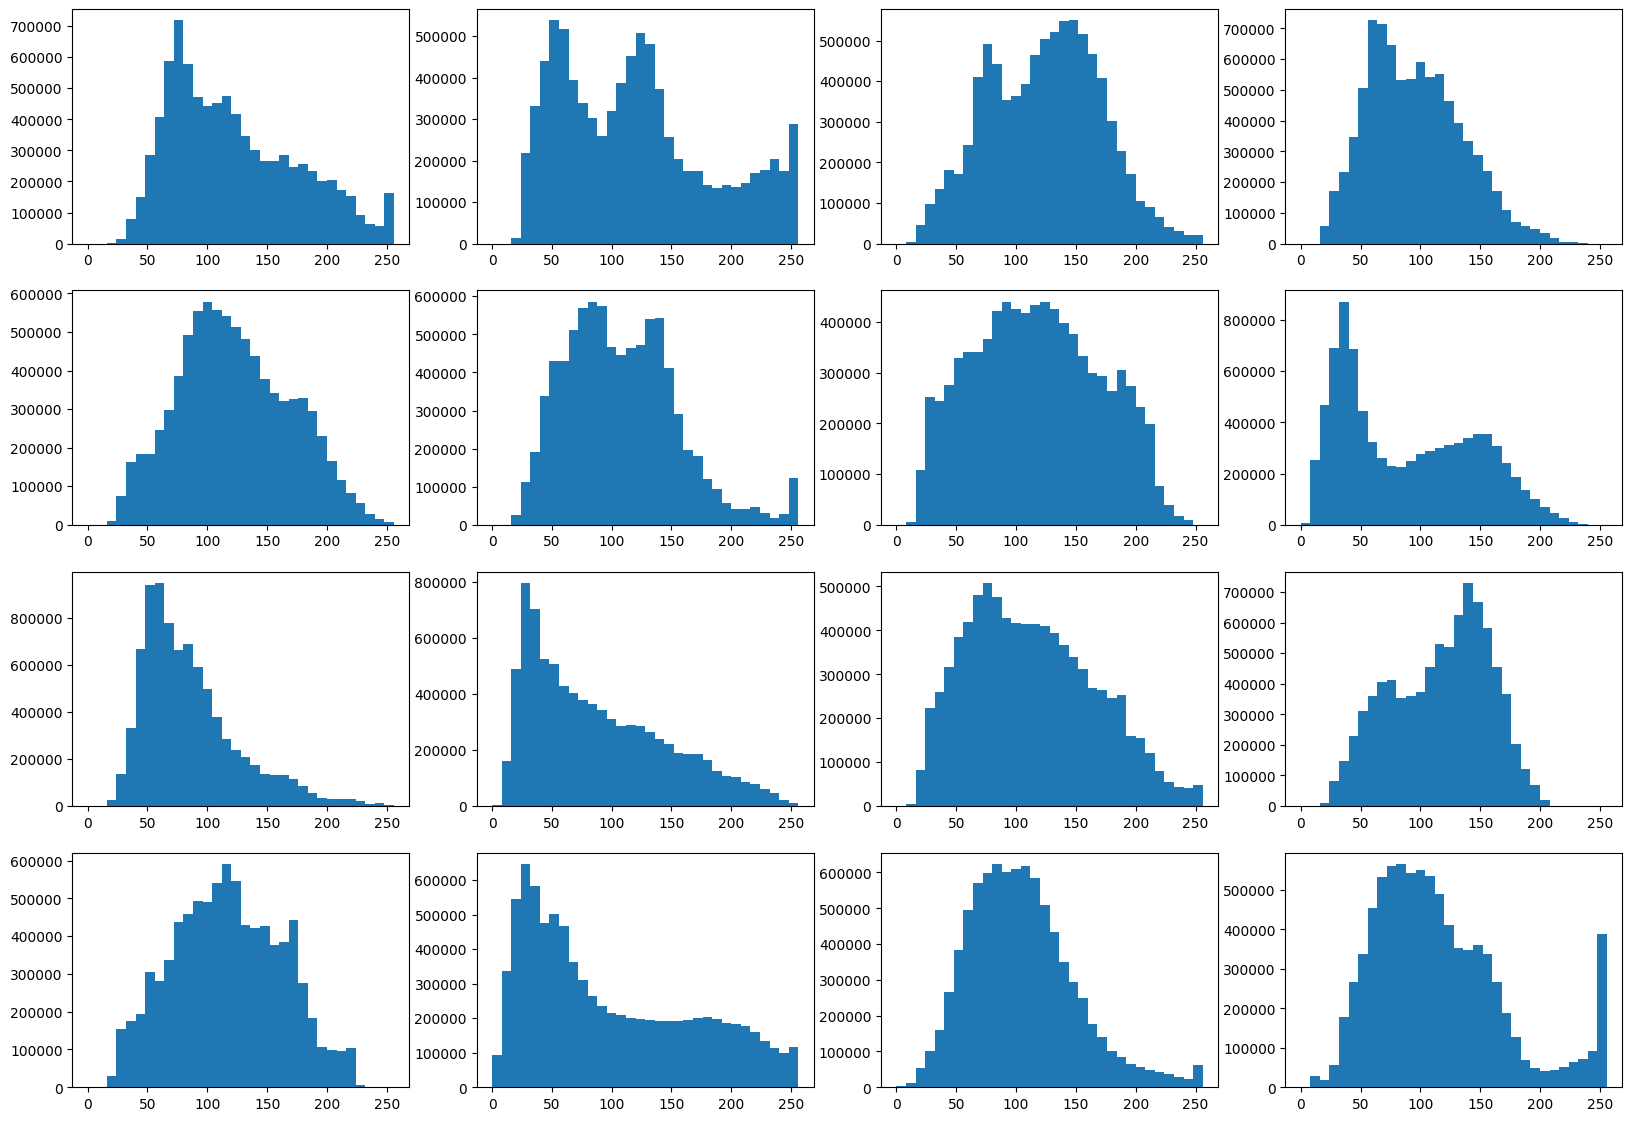

In [19]:
#Image segmentation using Histogram
w=10
h=10
fig=plt.figure(figsize=(20, 14))
columns = 4
rows = 4
plt.axis('off')
for i in range(1, columns*rows +1):
    img = plt.imread(f'/content/drive/MyDrive/Plant disease detection/images/Train_{i}.jpg')
    fig.add_subplot(rows, columns, i)
    plt.hist(img.ravel(), bins=32, range=[0, 256])
plt.show()

In [20]:
img.shape

(1365, 2048, 3)

In [21]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    zca_whitening=False,
    rotation_range=180,
    zoom_range = 0.15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    vertical_flip=True
)

In [22]:
X_train, X_valid = train_test_split(dataset, test_size=0.05, shuffle=False)

In [23]:
#making tensorflow datasets
BATCH_SIZE = 8
train_generator = datagen.flow_from_dataframe(dataset,
                                              directory='/content/drive/MyDrive/Plant disease detection/images/',
                                              x_col='image_id',
                                              y_col=['healthy', 'multiple_diseases','rust','scab'],
                                              target_size=(512,512),
                                              class_mode='raw',
                                              batch_size=BATCH_SIZE, shuffle=False)
valid_generator = datagen.flow_from_dataframe(X_valid,
                                              directory='/content/drive/MyDrive/Plant disease detection/images/',
                                              x_col='image_id',
                                              y_col=['healthy', 'multiple_diseases','rust','scab'],
                                              target_size=(512,512),
                                              class_mode='raw',
                                              batch_size=BATCH_SIZE, shuffle=False)

Found 1821 validated image filenames.
Found 92 validated image filenames.


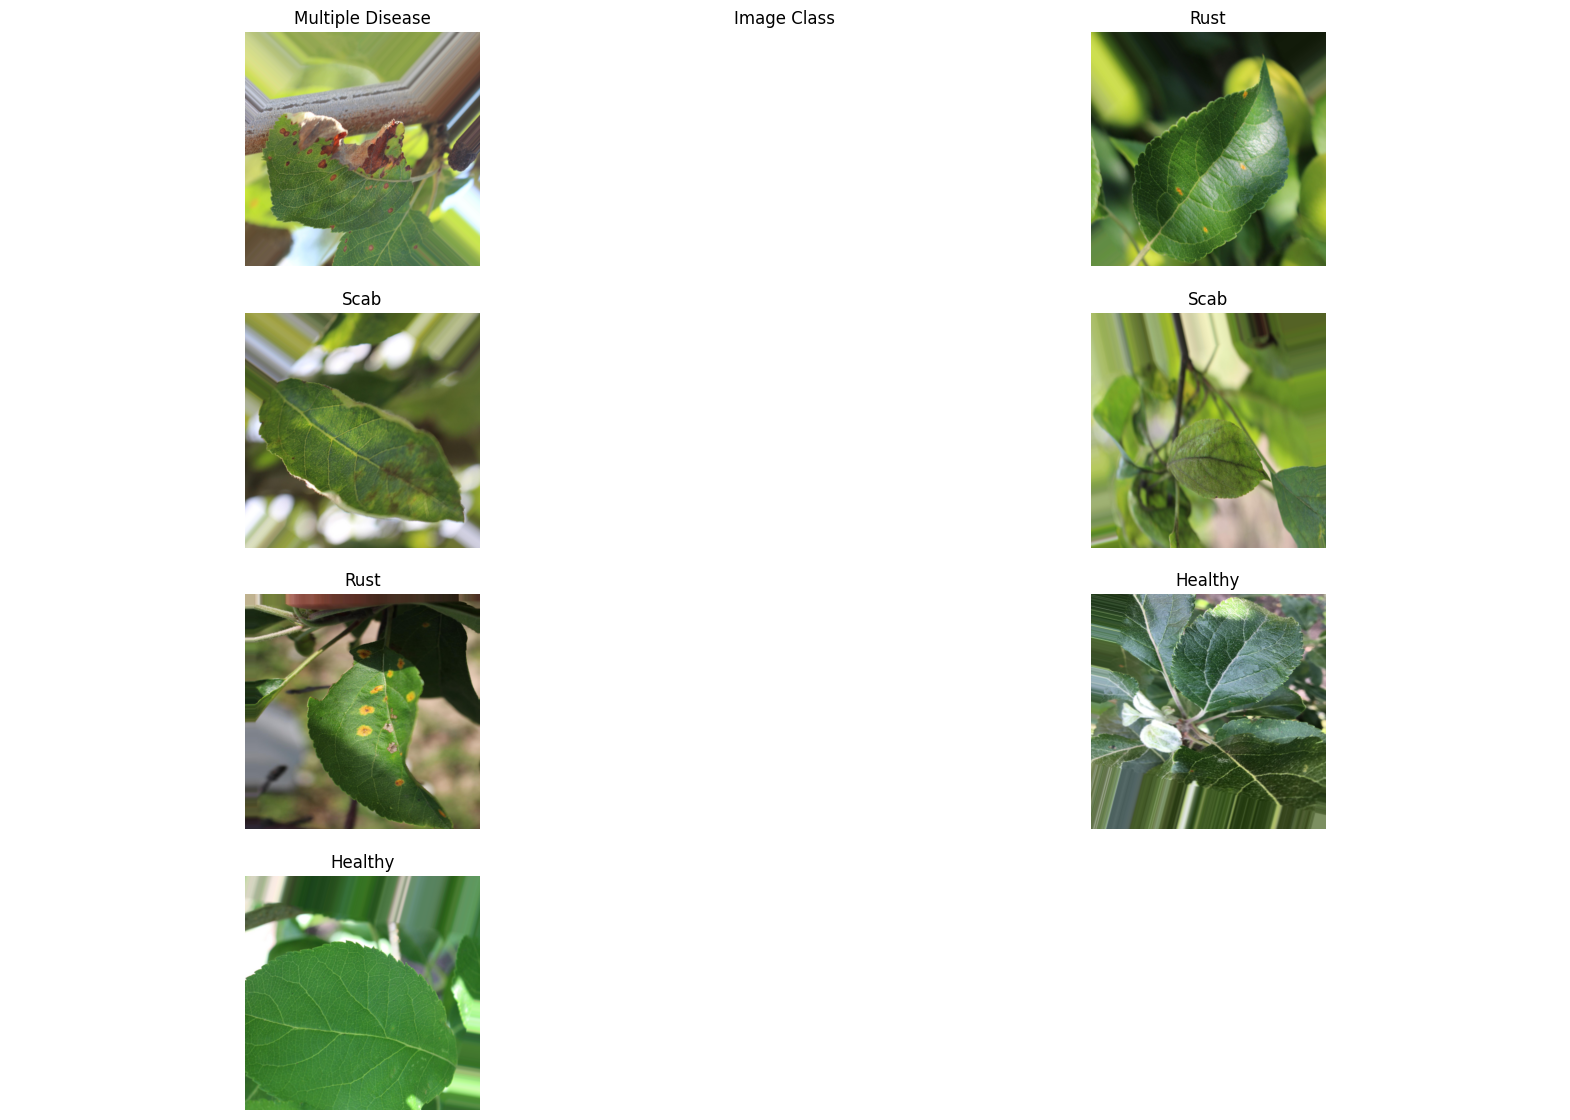

In [24]:
#Generator Images Visualisations
w=10
h=10
fig=plt.figure(figsize=(20, 14))
columns = 2
rows = 4
plt.title('Image Class')
plt.axis('off')
for i in range(1, columns*rows):
  img_batch,label_batch = train_generator.next()
  fig.add_subplot(rows, columns, i)

  if label_batch[i][0] == 1:
    plt.title('Healthy')
  elif label_batch[i][1] == 1:
    plt.title('Multiple Disease')
  elif label_batch[i][2] == 1:
    plt.title('Rust')
  else:
    plt.title('Scab')

  plt.imshow(img_batch[i])
  plt.axis('off')
plt.show()

In [25]:
#Xception Model
xception_model = tf.keras.models.Sequential([
    tf.keras.applications.xception.Xception(include_top=False, weights='imagenet', input_shape=(512, 512, 3)),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(4,activation='softmax')
])
xception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
xception_model.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 16, 16, 2048)      20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 20869676 (79.61 MB)
Trainable params: 20815148 (79.40 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________


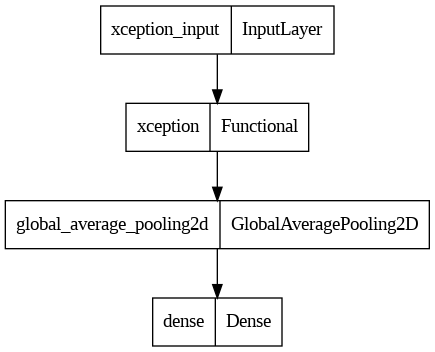

In [26]:
tf.keras.utils.plot_model(xception_model, to_file='xception_model.png')

In [27]:
densenet_model = tf.keras.models.Sequential([
    tf.keras.applications.densenet.DenseNet121(include_top=False, weights='imagenet',input_shape=(512, 512, 3)),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(4,activation='softmax')
])
densenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
densenet_model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 16, 16, 1024)      7037504   
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 4)                 4100      
                                                                 
Total params: 7041604 (26.86 MB)
Trainable params: 6957956 (26.54 MB)
Non-trainable params: 83648 (326.75 KB)
_________________________________________________________________


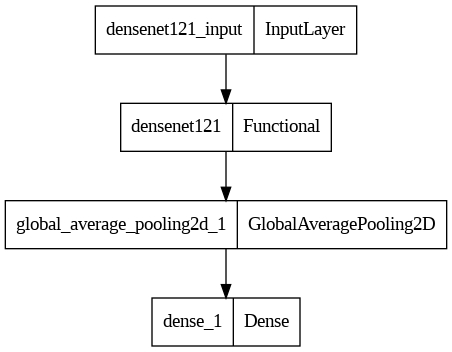

In [28]:
tf.keras.utils.plot_model(densenet_model, to_file='densenet_model.png')

In [29]:
inputs = tf.keras.Input(shape=(512, 512, 3))

xception_output = xception_model(inputs)
densenet_output = densenet_model(inputs)

outputs = tf.keras.layers.average([densenet_output, xception_output])

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 4)                    7041604   ['input_3[0][0]']             
                                                                                                  
 sequential (Sequential)     (None, 4)                    2086967   ['input_3[0][0]']             
                                                          6                                       
                                                                                                  
 average (Average)           (None, 4)                    0         ['sequential_1[0][0]',    

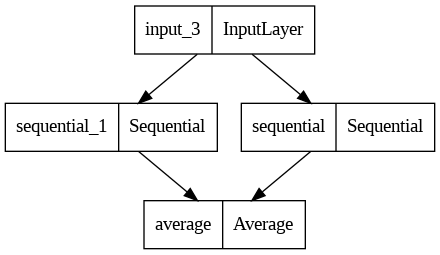

In [30]:
tf.keras.utils.plot_model(model, to_file='model.png')

Learning rate schedule: 1e-05 to 0.0001 to 1e-05


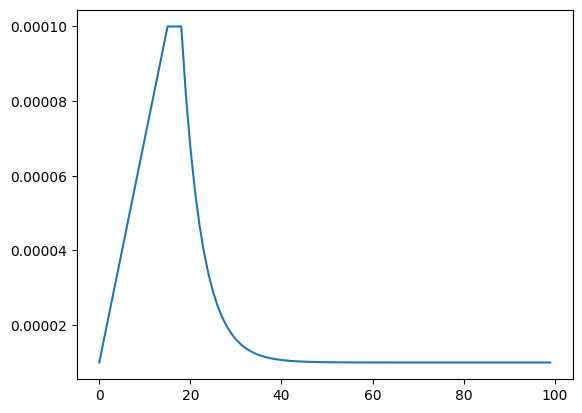

In [31]:
LR_START = 0.00001
LR_MAX = 0.0001
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 15
LR_SUSTAIN_EPOCHS = 3
LR_EXP_DECAY = .8
EPOCHS = 100

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))


In [32]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', verbose=2, save_best_only=True)

# Tensordash is used for getting live model training status, like accuracy or loss, in your phone, sure to checkout here: https://github.com/CleanPegasus/TensorDash
#histories = Tensordash(
   # email = secret_value_0,
   # password = secret_value_1,
#    ModelName = "Plant Disease Model")
